In [1]:
import sys
import os

# Expand the user path in project_path
project_path = os.path.expanduser('~/Desktop/Projet_MARL/gym-multigrid/gym_multigrid')

# Verify if the project_path exists
if os.path.exists(project_path):
    # Add the project_path to sys.path
    if project_path not in sys.path:
        sys.path.append(project_path)
    print(f"Added {project_path} to sys.path")
else:
    print(f"Error: The path {project_path} does not exist. Please check the project_path variable.")

# Import the required module
try:
    from gym_multigrid.envs import MARL_env
    print("Successfully imported MARL_env from gym_multigrid.")
except ModuleNotFoundError as e:
    print(f"Error: {e}. Ensure the gym_multigrid package is installed and accessible.")

Added /home/yacine/Desktop/Projet_MARL/gym-multigrid/gym_multigrid to sys.path
Successfully imported MARL_env from gym_multigrid.


In [ ]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from gym_multigrid.envs import MARL_env 

from matplotlib.colors import ListedColormap
from collections import deque
import random
import copy
from collections import OrderedDict
import pandas as pd
import time

seed = 0
np.random.seed(seed)
random.seed(seed)

In [3]:
class MultiAgentEnvWrapper:
    """
    Wrapper class for CustomMultiAgentEnv that distinguishes between training and testing phases
    """
    
    def __init__(self, is_testing=False, width=10, height=10, max_steps=100, seed=None,
                 agent_positions=None, goal_positions=None, walls=None):
        self.is_testing = is_testing
        self.width = width
        self.height = height
        self.max_steps = max_steps
        self.seed = seed
        self.envs = []  # stores all environments created
        self.initial_states = []
        
        if agent_positions is None or goal_positions is None:
            raise ValueError("agent_positions and goal_positions must be provided")
        
        # Training mode: one env per agent/goal pair
        if not is_testing:
            for agent_pos, goal_pos in zip(agent_positions, goal_positions):
                agents = [{"start": agent_pos, "goal": goal_pos}]
                env = MARL_env.CustomMultiAgentEnv(
                    width=width,
                    height=height,
                    max_steps=max_steps,
                    seed=seed,
                    agents=agents
                )
                
                # Add walls if specified
                if walls:
                    for wall_x, wall_y in walls:
                        env.add_wall(wall_x, wall_y)
                
                self.envs.append(env)
                self.initial_states.append(env.reset()[0])  # Get first agent's observation
        
        # Test mode: one env with all agents and goals
        else:
            agents = [{"start": start, "goal": goal} for start, goal in zip(agent_positions, goal_positions)]
            env = MARL_env.CustomMultiAgentEnv(
                width=width,
                height=height,
                max_steps=max_steps,
                seed=seed,
                agents=agents
            )
            
            # Add walls if specified
            if walls:
                for wall_x, wall_y in walls:
                    env.add_wall(wall_x, wall_y)
            
            self.envs.append(env)
            self.initial_states.append(env.reset())
    
    def reset(self, idx=0):
        return self.envs[idx].reset(), self.get_agent_position(idx=idx)
    def step(self, actions, idx=0):
        """
        Execute a step in the environment with the given actions for each agent.
        
        Args:
            actions: List of actions, one per agent or single action
            idx: Index of the environment to use
            
        Returns:
            observations: List of observations for each agent
            rewards: List of rewards for each agent
            terminated: If the episode is terminated by reaching goals
            truncated: If the episode is truncated by exceeding max steps
            info: Additional information
        """
        # Make sure we're using the right environment
        env = self.envs[idx]
        
        # Different handling for training vs testing
        if not self.is_testing:
            # Training mode - one action for one agent
            if not isinstance(actions, list):
                obs, rewards, terminated, truncated, info = env.step([actions])
                return obs[0], rewards[0], terminated, truncated, info  # Return just the first agent's results
            else:
                obs, rewards, terminated, truncated, info = env.step(actions)
                return obs[0], rewards[0], terminated, truncated, info  # Return just the first agent's results
        else:
            # Testing mode - list of actions for multiple agents
            if not isinstance(actions, list):
                # Convert single action to list if needed
                actions = [actions]
            
            # Make sure we have enough actions for all agents
            if len(actions) < len(env.agents):
                actions = actions + [0] * (len(env.agents) - len(actions))
            obs, rewards, terminated, truncated, info = env.step(actions)
            # Call the environment's step method
            return obs, rewards, terminated, truncated, info

    def visualize(self, idx=0, highlight_masks=None, show=True):
        """
        Visualize the environment at the specified index
        
        Args:
            idx: Index of the environment to visualize
            highlight_masks: Optional mask to highlight specific cells
            show: Whether to display the image (True) or just return it (False)
        
        Returns:
            numpy.ndarray: The rendered grid image
        """
        grid_image = self.envs[idx].visualize(highlight_masks=highlight_masks, show=show)
        return grid_image
    
    def get_action_space(self):
        # 0: left, 1: right, 2: forward, 3: toggle, 4: stay
        return list(range(5))
    
    def all_agents_at_goals(self, idx=0):
        return self.envs[idx].all_agents_at_goals()
    
    def run_random_agents(self, max_steps=100, idx=0):
        self.envs[idx].run_random_agents(max_steps)
    
    def get_agent_position(self, idx=0):
        """Get the current position of the agent."""
        if self.is_testing:
            return tuple(self.envs[0].agents[idx].pos)
        else:
            return tuple(self.envs[idx].agents[0].pos)
    def collision():
        return MARL_env.CustomMultiAgentEnv.are_agents_colliding()
    def get_agent_goal(self, idx=0):
        """
        Get the goal position of the agent.
        
        Args:
            idx: Index of the agent whose goal position to retrieve
            
        Returns:
            tuple: (x, y) coordinates of the agent's goal position
        """
        if self.is_testing:
            # In testing mode, get the goal for the specified agent
            env = self.envs[0]
            return tuple(env.agent_goals[idx])
        else:
            # In training mode, get the goal for the single agent in the environment
            env = self.envs[idx]
            return tuple(env.agent_goals[0])
    def get_lava_pos(self):
        """
        Get the positions of lava cells in the environment.
        
        Returns:
            list: List of (x, y) coordinates of lava positions
        """
        return self.envs[0].lava_positions

In [ ]:
# Define agent positions and goals
agent_positions = [(1, 8), (9, 8), (1, 3)]
goal_positions = [(8, 8), (8, 2), (7, 7)]
walls = [(i, 5) for i in range(3, 7)]
SHAPE = (20, 20)
# Create training environment (one env per agent)
train_env = MultiAgentEnvWrapper(
    is_testing=False,
    width=20,
    height=20,
    agent_positions=agent_positions,
    goal_positions=goal_positions,
    walls=walls
)
print("agent_goal", train_env.get_agent_goal(idx=0))
print("lava_pos", train_env.get_lava_pos())
# Training example
print("Training mode example (first agent):")

# Replace the line: train_env.run_random_agents(max_steps=100, idx=0)
# With this code to make agent 0 move right for 5 steps:

print("Making agent 0 move right for 5 steps:")



# In CollectActions/CustomSmallActions:
# right = 1 (or east = 1 in CollectActions)
right_action = 3
Rewards=0
Re=[]
print("before reset")

for step in range(9):
    # Step the environment with the right action
    obs, rewards, terminated, truncated, info= train_env.step(right_action, idx=0)
    train_env.visualize()  # Visualize the state
    print(f"Observation: {obs}")
    print(f"info: {info}")
    
    Rewards+=rewards
    Re.append(Rewards)
    print(f"Step {step+1}: Agent moved right")



# Créer un highlight_mask personnalisé
highlight_masks = np.empty((train_env.width, train_env.height), dtype=object)
for i in range(train_env.width):
    for j in range(train_env.height):
        highlight_masks[i, j] = []

# Accéder à world via l'environnement sous-jacent (idx=0 pour le premier environnement)
env_world = train_env.envs[0].world

# Mettre en évidence un chemin
path = [(1,1), (2,1), (3,2), (4,2)]
for i, (x, y) in enumerate(path):
    highlight_masks[x, y] = [i % len(env_world.IDX_TO_COLOR)]

# Visualiser avec le highlight_mask personnalisé



# Show final state

plt.plot(Re)
plt.xlabel('Steps')
plt.ylabel('Rewards')
plt.title('Rewards over steps')
plt.show()
# Create test environment (all agents in one env)
test_env = MultiAgentEnvWrapper(
    is_testing=True,
    width=20,
    height=20,
    agent_positions=agent_positions,
    goal_positions=goal_positions,
    walls=walls
)

# Test example
print("Test mode example (all agents):")
Rewards = np.zeros(len(agent_positions))
Re = [[] for _ in range(len(agent_positions))]  # Initialize lists for each agent

test_env.reset(0)  # Réinitialiser l'environnement
test_env.visualize()  # Visualiser l'état propre
for step in range(10):
    # Move all agents east
    obs, rewards, terminated, truncated, info = test_env.step([2, 1, 2], idx=0)
    # Check for collisions using the collision function
    if any(info['collisions']):
        print(f"Collision detected at step {step+1}!")
        # Mark collision cells as red in visualization
        agent_positions = [test_env.get_agent_position(idx=i) for i in range(len(agent_positions))]
        
        # Find positions where agents are colliding
        position_counts = {}
        for pos in agent_positions:
            if pos in position_counts:
                position_counts[pos] += 1
            else:
                position_counts[pos] = 1
        
        collision_positions = [pos for pos, count in position_counts.items() if count > 1]
        test_env.collision_positions = collision_positions
        break
    print(f"rewards: {rewards}")
    Rewards += np.array(rewards)
    for i in range(len(rewards)):
        Re[i].append(rewards[i])    
    print(f"Step {step+1}: All agents moved forward")
    
    # Check if all agents reached their goals
    if test_env.all_agents_at_goals(idx=0):
        print("All agents reached their goals!")
        break


plt.plot(Re[0], label='Agent 1')
plt.plot(Re[1], label='Agent 2')
plt.plot(Re[2], label='Agent 3')
plt.xlabel('Steps')
plt.ylabel('Rewards')
plt.title('Rewards over steps')
plt.legend()
plt.show()

In [5]:
class DynaQLearningAgent:

    def __init__(self, 
                 state_dim, 
                 action_dim, 
                 lr=0.1, 
                 gamma=0.99, 
                 epsilon=0.1,
                 n_planning=10):
        
        # environment
        self.state_dim = state_dim
        self.action_dim = action_dim

        # hyperparameters
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_planning = n_planning

        # model
        self.q_table = dict()
        self.model = dict()

    def action_space(self):
        return [0, 1, 2, 3, 4]  # UP, DOWN, LEFT, RIGHT, STOP

    def best_action(self, array):

        max_value = np.max(array)
        max_indices = np.where(array == max_value)[0]
        action = np.random.choice(max_indices)

        return action
    
    def select_action(self, state, eval=False):
        
        state_index = self.state_to_position(state)

        if state_index not in self.q_table:
            self.q_table[state_index] = np.zeros(self.action_dim)
        
        if not eval and np.random.rand() < self.epsilon:
            return np.random.choice(self.action_dim)

        action = np.argmax(self.q_table[state_index])
        # action = self.best_action(self.q_table[state_index])
        # if eval:
        #     return np.argmax(self.q_table[state_index])
        
        return action
    
    def q_learning(self, state, action, reward, next_state, done): 

        td_target = reward + self.gamma * (np.max(self.q_table[next_state])) * (1 - done)
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.lr * td_error

    def q_planning(self):
        for _ in range(self.n_planning):
            (state, action), (reward, state_next, done) = random.choice(list(self.model.items()))
            self.q_learning(state, action, reward, state_next, done)

    
    def update(self, state, action, reward, next_state, done):

        state_index = (self.state_to_position(state))
        next_state_index = (self.state_to_position(next_state))
        
        if state_index not in self.q_table:
            self.q_table[state_index] = np.zeros(self.action_dim)

        if next_state_index not in self.q_table:
            self.q_table[next_state_index] = np.zeros(self.action_dim)

        self.q_learning(state_index, action, reward, next_state_index, done)
        self.model[(state_index, action)] = reward, next_state_index, done 
        self.q_planning()
        
    def state_to_position(self, state):
        """
        Convert state to a hashable position representation.
        
        Args:
            state: Can be:
                - A tuple (x, y)
                - A tuple containing (observation, position)
                - A list [x, y]
                - A numpy array observation
            
        Returns:
            A hashable tuple representing the agent's position
        """
        if isinstance(state, tuple):
            # Check if this is a tuple of (observation, position)
            if len(state) == 2 and isinstance(state[1], tuple):
                return state[1]  # Return the position part
            return state  # It's already a position tuple
        elif isinstance(state, list):
            return tuple(state)  # Convert list to tuple
        elif isinstance(state, np.ndarray):
            # If state is a full observation array and we have env reference
            if hasattr(self, 'env_wrapper') and hasattr(self, 'agent_idx'):
                return self.env_wrapper.get_agent_position(self.agent_idx)
            else:
                print("Cannot extract position from numpy array without env_wrapper reference")
                return (0, 0)  # Default fallback
        else:
            print(f"Error: Unexpected state type: {type(state)}")
            return (0, 0)  # Default fallback

    def print_tables(self, name):
        if name == 'qtable':
            table = self.q_table
            print(f"{len(table)} out of {(SHAPE[0])*(SHAPE[1])} grids have been reached.")
            col_names=['UP', 'DOWN', 'LEFT', 'RIGHT', 'STOP']
            # col_names=['UP', 'DOWN', 'LEFT', 'RIGHT']
        elif name == 'model':
            table = self.model
            print(f"{len(self.model)} out of {(SHAPE[0])*(SHAPE[1])*self.action_dim} possibilities have been memorized.")
            col_names=['Reward', 'NextState', 'Done']
        else:
            print("Invalid table name.")
            return

        ordered_coords_dict =  OrderedDict(sorted(table.items())).copy()
        df = pd.DataFrame.from_dict(ordered_coords_dict, orient='index', columns=col_names)
        df = df.round(2)
        print(df)

        return [len(table), (SHAPE[0]-2)*(SHAPE[1]-2), len(self.model), (SHAPE[0]-2)*(SHAPE[1]-2)*self.action_dim]
    
    def tables_2(self):
        return [len(self.q_table), len(self.model)]

In [6]:
def train_agent(env_wrapper, agent: DynaQLearningAgent, num_episodes=1000, max_steps=1000, print_process=True, agent_idx=0):
    """
    Entraîne un agent dans un environnement donné (env_wrapper) sur plusieurs épisodes.
    """
    all_rewards = []

    for episode in range(num_episodes):
        # Reset environment and get initial state (which now includes position)
        state = env_wrapper.reset(agent_idx)  # This now returns (observation, position)
        total_reward = 0
        
        if print_process and episode % 10 == 0:
            print(f"Episode {episode}, Agent {agent_idx+1}")
        
        for i in range(max_steps):
            action = agent.select_action(state, eval=False)
            next_state, reward, terminated, truncated, info = env_wrapper.step(action, agent_idx)
            done = terminated or truncated
            
            agent.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            
            if done:
                break

        all_rewards.append(total_reward)

        if print_process and episode % 10 == 0:
            print(f"Episode {episode}, Total Reward for Agent {agent_idx+1}: {total_reward}")
    
    return all_rewards
def smooth(data, weight=0.9):  
    """
    Lisse les données en utilisant un facteur de pondération (smooth).
    :param data: La liste des données à lisser.
    :param weight: Le facteur de pondération utilisé pour le lissage.
    :return: La liste des données lissées.
    """
    last = data[0]
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards_for_all_agents(all_rewards, filename='rewards.png'):
    """
    Trace les récompenses pour tous les agents après l'entraînement.
    
    :param all_rewards: Une liste des récompenses pour chaque agent.
    :param filename: Le nom du fichier pour enregistrer le graphique.
    """
    plt.figure(figsize=(10, 6))

    for idx, rewards in enumerate(all_rewards):
        smoothed_rewards = smooth(rewards)  # Lissage des récompenses
        plt.plot(smoothed_rewards, label=f"Agent {idx+1}")  # Tracer les récompenses lissées
    
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Q-learning for Multiple Agents')
    plt.legend()
    plt.show()

    print(f"Plot saved as {filename}")

def train_all_agents(env_wrapper, agents, num_episodes=1000, max_steps=1000):
    """
    Entraîne plusieurs agents indépendamment dans un environnement multi-agent.
    
    :param env_wrapper: Le wrapper de l'environnement avec plusieurs agents.
    :param agents: Une liste d'agents à entraîner.
    :param num_episodes: Nombre d'épisodes pour l'entraînement de chaque agent.
    :param max_steps: Nombre maximal d'étapes par épisode.
    :return: Une liste des récompenses pour chaque agent.
    """
    all_agents_rewards = []
    
    for idx, agent in enumerate(agents):
        print(f"\nTraining Agent {idx+1}...")
        agent_rewards = train_agent(env_wrapper, agent, num_episodes, max_steps, agent_idx=idx)
        all_agents_rewards.append(agent_rewards)
    
    return all_agents_rewards
# Après l'entraînement de tous les agents, vous pouvez afficher leur Q-table comme suit :

def print_qtables(agents):
    for idx, agent in enumerate(agents):
        print(f"\nQ-table for Agent {idx+1}:")
        agent.print_tables('qtable')  # Utilise la fonction print_tables pour afficher la Q-table





In [7]:
def visualize_q_path(env_wrapper, agents, max_steps=20):
    """
    Visualize the path taken by agents based on their Q-tables, showing the environment after each step.
    
    Args:
        env_wrapper: The environment wrapper containing all environments
        agents: List of trained agents with Q-tables
        max_steps: Maximum number of steps to visualize
    """
    # Reset all environments and get initial states
    states = []
    for idx in range(len(env_wrapper.envs)):
        state = env_wrapper.reset(idx)
        states.append(state)
        
        env_wrapper.visualize(idx)
    
    # Keep track of whether each agent has reached its goal
    done_flags = [False] * len(agents)
    
    # For keeping track of rewards and paths
    total_rewards = [0] * len(agents)
    paths = [[] for _ in range(len(agents))]
    
    # For each step
    for step in range(max_steps):
        print(f"\n--- Step {step+1} ---")
        all_done = True
        
        # For each agent
        for idx, agent in enumerate(agents):
            if done_flags[idx]:
                print(f"Agent {idx+1} already reached goal.")
                continue
            
            # Get current state
            current_state = states[idx]
            
            # Get the best action according to Q-table
            action = agent.select_action(current_state, eval=True)
            
            # Get position and Q-values for current state
            state_pos = agent.state_to_position(current_state)
            if state_pos in agent.q_table:
                q_values = agent.q_table[state_pos]
                best_q = np.max(q_values)
               
            
            # Take the action
            next_state, reward, done, _ ,_= env_wrapper.step(action, idx=idx)
            total_rewards[idx] += reward
            
            # Update state
            states[idx] = next_state
            paths[idx].append((state_pos, action))
            
            # Visualize the current state after action
            
            env_wrapper.visualize(idx)
            
            # Check if done
            if done:
                print(f"Agent {idx+1} reached goal or episode ended!")
                done_flags[idx] = True
            
            # Check if any agent is still active
            if not done_flags[idx]:
                all_done = False
        
        # If all agents are done, end visualization
        if all_done:
            print("\n🎉 All agents have reached their goals!")
            break
    
    # Print summary
    print("\n--- Summary ---")
    for idx, rewards in enumerate(total_rewards):
        print(f"Agent {idx+1}: Total reward = {rewards:.2f}")
        print(f"Path taken: {paths[idx]}")
    
    return total_rewards, paths




In [8]:
def visualize_multiagent_test(agents, max_steps=50,test_env=None):
    """
    Visualize all agents together in a test environment using their 
    pre-trained Q-tables to make decisions.
    
    Args:
        agents: List of trained DynaQLearningAgent objects with Q-tables
        max_steps: Maximum number of steps to run the visualization
    """
    # Create a new test environment with all agents

    
    # Reset the environment to get initial state
    state, info = test_env.reset()
   
    test_env.visualize()
    
    # For tracking rewards, paths, and done status
    total_rewards = [0] * len(agents)
    paths = [[] for _ in range(len(agents))]
    done = False
    
    # For each step
    for step in range(max_steps):
        print(f"\n--- Step {step+1} ---")
        
        # Determine action for each agent based on its trained Q-table
        actions = []
        
        for idx, agent in enumerate(agents):
            current_state = test_env.get_agent_position(idx=idx)
            
          
            action = agent.select_action(current_state, eval=True)
            actions.append(action)
          
        obs, rewards, terminated, truncated, info = test_env.step(actions)
        if test_env.all_agents_at_goals(idx=0):
            print("All agents reached their goals!")
            done = True
            break
        test_env.visualize()
    return total_rewards, paths
# Visualize all agents in a test environment


### Unsafe sets and Reachable sets


In [46]:
def compute_reachable_states(env, agent_idx=0, start_pos=None, n_steps=5):
    """
    Computes all states reachable for an agent in n_steps.
    
    Args:
        env: The MultiAgentEnvWrapper environment
        agent_idx: Index of the agent to compute reachable states for
        start_pos: Optional starting position, defaults to agent's current position
        n_steps: Number of steps to look ahead
        
    Returns:
        tuple: (reachable_by_step, all_reachable)
            - reachable_by_step: Dict mapping step number to set of positions {step: {positions}}
            - all_reachable: Set of all reachable positions
    """
    # Reset environment to get initial state if needed
    if start_pos is None:
        if env.is_testing:
            # In testing mode, there's only one environment (index 0) with multiple agents
            obs_tuple = env.reset(0)  # Always reset env 0 in testing mode
            start_pos = env.get_agent_position(idx=agent_idx)  # Get position for the specific agent
        else:
            # In training mode, reset the specific agent's environment
            if agent_idx < len(env.envs):
                obs_tuple = env.reset(agent_idx)
                # Extract position from reset's return value
                if isinstance(obs_tuple, tuple) and len(obs_tuple) == 2:
                    start_pos = obs_tuple[1]
                else:
                    start_pos = env.get_agent_position(idx=agent_idx)
            else:
                return {}, set()
    
    # Create queue for BFS search
    queue = deque([(start_pos, 0)])  # (position, steps_taken)
    visited = {start_pos}  # Track visited states
    reachable = {0: {start_pos}}  # Reachable states by steps: {steps: {positions}}
    
    # Define movement actions (0=stay, 1=west, 2=east, 3=north, 4=south)
    actions = [0, 1, 2, 3, 4]  # Include 0 (stay) for reachability analysis
    
    # Run BFS to find all reachable states
    while queue:
        pos, steps = queue.popleft()
        
        if steps >= n_steps:
            continue
            
        # Try each action
        for action in actions:
            next_pos_array = np.array(pos)
            
            # Traitement explicite pour l'action "stay"
            if action == 0:
                next_pos = pos  # Rester sur place
            elif action == 1:  # west/left
                next_pos_array[0] -= 1
                next_pos = tuple(next_pos_array)
            elif action == 2:  # east/right
                next_pos_array[0] += 1
                next_pos = tuple(next_pos_array)
            elif action == 3:  # north/up
                next_pos_array[1] -= 1
                next_pos = tuple(next_pos_array)
            elif action == 4:  # south/down
                next_pos_array[1] += 1
                next_pos = tuple(next_pos_array)
            
            # Pour l'action 0 (stay), nous n'avons pas besoin de vérifier les limites
            # ou les murs car la position ne change pas
            if action == 0:
                if next_pos not in visited:
                    visited.add(next_pos)
                    queue.append((next_pos, steps + 1))
                    
                    # Add to reachable states for this step count
                    if steps + 1 not in reachable:
                        reachable[steps + 1] = set()
                    reachable[steps + 1].add(next_pos)
                continue
            
            # Check boundaries
            if (0 <= next_pos_array[0] < env.width and 
                0 <= next_pos_array[1] < env.height):
                # For wall checking, we need a reference to the grid
                if env.is_testing:
                    grid = env.envs[0].grid
                else:
                    # Make sure agent_idx is within range
                    if agent_idx < len(env.envs):
                        grid = env.envs[agent_idx].grid
                    else:
                        # Skip if agent_idx is out of range
                        continue
                
 
                next_pos = tuple(next_pos_array)
                
                # If this is a new reachable state
                if next_pos not in visited:
                    visited.add(next_pos)
                    queue.append((next_pos, steps + 1))
                    
                    # Add to reachable states for this step count
                    if steps + 1 not in reachable:
                        reachable[steps + 1] = set()
                    reachable[steps + 1].add(next_pos)
    
    # Flatten all reachable states
    all_reachable = set()
    for step in reachable:
        all_reachable.update(reachable[step])
    
    return reachable, all_reachable

def n_unsafe_set(env, agent_idx1=0, agent_idx2=1, n=5):
    """
    Computes the unsafe set for two agents in n steps.
    
    Args:
        env: The environment wrapper
        agent_idx1: Index of the first agent
        agent_idx2: Index of the second agent
        n: Number of steps to look ahead
        
    Returns:
        dict: Unsafe states where both agents could potentially collide, by step
    """
    # Check if we have enough agents in the environment
    if env.is_testing:
        # In testing mode, check agents in the single environment
        num_agents = len(env.envs[0].agents) if env.envs else 0
    else:
        # In training mode, count the number of environments
        num_agents = len(env.envs)
        
    # Validate agent indices
    if agent_idx1 >= num_agents or agent_idx2 >= num_agents:
        
        return {}  # Return empty dict to match expected return type for from_reachable_to_mask
    
    # Get reachable states for both agents
    _, all_reachable_agent_1 = compute_reachable_states(env, agent_idx=agent_idx1, n_steps=n)
    _, all_reachable_agent_2 = compute_reachable_states(env, agent_idx=agent_idx2, n_steps=n)
    
    
    # Compute intersection of all reachable positions
    intersections = all_reachable_agent_1.intersection(all_reachable_agent_2)
    
    # Store intersections under a single key to match the expected return format
    unsafe_set = {0: intersections} if intersections else {}
    
    return unsafe_set

def from_reachable_to_mask(reachable_by_step, env_width, env_height, env, fixed_color=None):
    """
    Convert reachable states to a mask for visualization with better color control.

    Args:
        reachable_by_step: Dict mapping step number to set of positions {step: {positions}}
        env_width: Width of the environment
        env_height: Height of the environment
        env: Reference to environment wrapper
        fixed_color: If provided, use this color index for all positions
        
    Returns:
        np.ndarray: Mask with reachable states
    """
    # Create a 2D array of lists to store highlight colors at each position
    mask = np.empty((env_width, env_height), dtype=object)
    for i in range(env_width):
        for j in range(env_height):
            mask[i, j] = []

    # Get reference to the world object for colors
    env_world = env.envs[0].world
    color_count = len(env_world.IDX_TO_COLOR)
    
   
    # Count total positions to process
    total_positions = sum(len(positions) for positions in reachable_by_step.values())
   
    
    # Add highlights for each step and position
    for step, positions in reachable_by_step.items():
     
        for pos in positions:
            x, y = pos
            if 0 <= x < env_width and 0 <= y < env_height:
                # Use fixed color if provided, otherwise use step % colors
                color = fixed_color if fixed_color is not None else (step % color_count)
                mask[x, y].append(color)
    
    return mask
# def K_agents_n_unsafe_set(env, agent_idx=0, n_steps=4, exclude_indices=None):
#     """
#     Computes the unsafe set for a specific agent by considering its interaction
#     with all other agents in the environment.
    
#     Args:
#         env: The MultiAgentEnvWrapper environment
#         agent_idx: Index of the agent for which to compute the unsafe set
#         n_steps: Number of steps to look ahead
#         exclude_indices: Optional list of agent indices to exclude from the computation
        
#     Returns:
#         dict: Unsafe set for the specified agent, combining all pairwise unsafe sets
#     """
#     # Determine the number of agents in the environment
#     if env.is_testing:


#         num_agents = len(env.envs[0].agents) if env.envs else 0
#     else:
#         num_agents = len(env.envs)
    
#     # Initialize empty combined unsafe set
#     combined_unsafe_set = {}
    
#     # Initialize exclude_indices if None
#     if exclude_indices is None:
#         exclude_indices = []
    
#     # Make sure agent_idx itself is excluded
#     if agent_idx not in exclude_indices:
#         exclude_indices.append(agent_idx)

    
#     # For each other agent, compute the pairwise unsafe set
#     for other_idx in range(num_agents):
#         if other_idx in exclude_indices:
#             continue

        
#         # Compute pairwise unsafe set between agent_idx and other_idx
#         pairwise_unsafe = n_unsafe_set(env, agent_idx1=agent_idx, agent_idx2=other_idx, n=n_steps)
        
#         # Merge with the combined unsafe set
#         for step, positions in pairwise_unsafe.items():
#             if step not in combined_unsafe_set:
#                 combined_unsafe_set[step] = set()
#             combined_unsafe_set[step].update(positions)
    
#     # Print statistics about the combined unsafe set
#     total_unsafe_cells = sum(len(positions) for positions in combined_unsafe_set.values())

    
#     return combined_unsafe_set


def K_agents_n_unsafe_set(env, agent_idx=0, n_steps=4, exclude_indices=None):
    """
    Computes the unsafe set for a specific agent by considering its interaction
    with all other agents in the environment. Also counts how many times each position
    is shared among different agents.
    
    Args:
        env: The MultiAgentEnvWrapper environment
        agent_idx: Index of the agent for which to compute the unsafe set
        n_steps: Number of steps to look ahead
        exclude_indices: Optional list of agent indices to exclude from the computation
        
    Returns:
        dict: Unsafe set for the specified agent with counts of how many agents share each position
    """
    # Determine the number of agents in the environment
    if env.is_testing:
        num_agents = len(env.envs[0].agents) if env.envs else 0
    else:
        num_agents = len(env.envs)
    
    # Initialize empty combined unsafe set
    # Instead of using sets, we'll use dictionaries to track counts
    combined_unsafe_set = {}
    position_counts = {}  # To track counts for each position
    
    # Initialize exclude_indices if None
    if exclude_indices is None:
        exclude_indices = []
    
    # Make sure agent_idx itself is excluded
    if agent_idx not in exclude_indices:
        exclude_indices.append(agent_idx)
    
    # For each other agent, compute the pairwise unsafe set
    for other_idx in range(num_agents):
        if other_idx in exclude_indices:
            continue
        
        # Compute pairwise unsafe set between agent_idx and other_idx
        pairwise_unsafe = n_unsafe_set(env, agent_idx1=agent_idx, agent_idx2=other_idx, n=n_steps)
        
        # Merge with the combined unsafe set and update counts
        for step, positions in pairwise_unsafe.items():
            if step not in combined_unsafe_set:
                combined_unsafe_set[step] = set()
                position_counts[step] = {}
            
            # Update the set of positions
            combined_unsafe_set[step].update(positions)
            
            # Update count for each position
            for pos in positions:
                if pos not in position_counts[step]:
                    position_counts[step][pos] = 1
                else:
                    position_counts[step][pos] += 1
    
    # Print statistics about the combined unsafe set
    total_unsafe_cells = sum(len(positions) for positions in combined_unsafe_set.values())
    
    # Create a dictionary of positions with their counts
    unsafe_with_counts = {}
    for step, positions in combined_unsafe_set.items():
        unsafe_with_counts[step] = {pos: position_counts[step][pos] for pos in positions}
    
    return unsafe_with_counts

def visualize_all_agents_unsafe_sets(env_wrapper, n_steps=4):
    """
    Visualizes the unsafe sets for all agents in the environment.
    
    Args:
        env_wrapper: The MultiAgentEnvWrapper environment
        n_steps: Number of steps to look ahead for computing unsafe sets
    """
    # Determine the number of agents
    if env_wrapper.is_testing:
        num_agents = len(env_wrapper.envs[0].agents) if env_wrapper.envs else 0
    else:
        num_agents = len(env_wrapper.envs)
    
    
    
    # Get the environment dimensions
    env_width = env_wrapper.width
    env_height = env_wrapper.height
    
    # For each agent, compute and visualize its unsafe set
    for agent_idx in range(num_agents):
        
        
        # Compute the unsafe set for this agent
        unsafe_set = K_agents_n_unsafe_set(
            env_wrapper, 
            agent_idx=agent_idx, 
            n_steps=n_steps
        )
        
        # Convert the unsafe set to a visualization mask
        unsafe_mask = from_reachable_to_mask(
            unsafe_set, 
            env_width, 
            env_height, 
            env_wrapper,
            fixed_color=0  # Use red for unsafe areas
        )
        
        # Get the agent's current position
        agent_pos = env_wrapper.get_agent_position(idx=agent_idx)
        
        
        # Get the agent's goal position
        goal_pos = goal_positions[agent_idx] if agent_idx < len(goal_positions) else None
        
        
        # Count total unsafe cells
        total_unsafe_cells = sum(len(positions) for positions in unsafe_set.values())
        
        
        # Visualize the environment with the unsafe set
        
        env_wrapper.visualize(highlight_masks=unsafe_mask)
        
        # Add a separator for clarity
        
    # Define agent positions in a cycle (each agent's goal is the next agent's position)


### Model 


In [10]:
def model(env, agent_idx, state, action, unsafe_set_dict=None):
    """
    Simule l'exécution d'une action à partir d'un état donné, en tenant compte des états dangereux.
    
    Args:
        env: L'environnement MultiAgentEnvWrapper
        agent_idx: L'indice de l'agent concerné
        state: La position actuelle de l'agent (tuple)
        action: L'action à simuler (0=stay, 1=west, 2=east, 3=north, 4=south)
        unsafe_set_dict: Dictionnaire d'états dangereux par étape {step: {positions}}
    
    Returns:
        tuple: (reward, next_state, done)
            - reward: La récompense obtenue pour cette transition
            - next_state: La position suivante de l'agent (tuple)
            - done: Booléen indiquant si l'épisode est terminé
    """
    # Valeur par défaut pour le reward
    reward = -1.0  # Pénalité par défaut pour chaque étape
    done = False
    # Obtenir l'environnement interne approprié
    agent_goal_pos = env.get_agent_goal(agent_idx)
    lava_positions = env.get_lava_pos() if hasattr(env, 'get_lava_pos') else []
    
    # Déterminer quel environnement et quelle grille utiliser
    if env.is_testing:
        grid = env.envs[0].grid
    else:
        grid = env.envs[agent_idx].grid
    next_state_array = np.array(state)
    # Simulation de l'action
    if action==0:
        next_state = state 
        reward=-5 # Rester sur place
        # Convertir l'état en tableau numpy pour la manipulation
    
    if action == 1:  # west/left
        next_state_array[0] -= 1
    elif action == 2:  # east/right
        next_state_array[0] += 1
    elif action == 3:  # north/up
        next_state_array[1] -= 1
    elif action == 4:  # south/down
        next_state_array[1] += 1
    # action 0 (stay) ne change pas la position
    
    # Vérifier les limites de la grille et les obstacles
    if (0 <= next_state_array[0] < env.width and 
        0 <= next_state_array[1] < env.height):
        next_state = tuple(next_state_array)
        
        # Vérifier s'il s'agit d'un mur ou d'un obstacle infranchissable
        grid_obj = grid.get(next_state[0], next_state[1])
        if grid_obj and not (hasattr(grid_obj, 'can_enter') and grid_obj.can_enter()):
            # Si c'est un mur, rester à la position actuelle et appliquer pénalité
            next_state = state
            # Pénalité pour ne pas pouvoir bouger (similaire à la pénalité dans MARL_env)
  
            reward = -2
        else:
            # Vérifier si l'agent a atteint son but
            if agent_goal_pos and next_state == agent_goal_pos:
                reward = 50  # Grande récompense pour atteindre l'objectif
                done = True
            
            # Vérifier si l'agent est sur une cellule de lave
            elif lava_positions and next_state in lava_positions:
                reward = -50.0  # Forte pénalité pour la lave
            
            # Vérifier si l'état suivant est dangereux (collision potentielle)
            elif unsafe_set_dict:
                # Vérifier si le prochain état est dans l'ensemble dangereux
                for step, positions_with_counts in unsafe_set_dict.items():
                    if next_state in positions_with_counts:
                        # Obtenir le compte pour cette position
                        count = positions_with_counts[next_state]
                        # Calculer la pénalité en fonction du compte (-2 * nombre d'agents qui peuvent atteindre cet état)
                        reward = - (count+1)  # Pénalité logarithmique
                        break  # Sortir de la boucle une fois la pénalité appliquée
    else:
        # Si hors limites, rester à la position actuelle
        next_state = state
        # Pénalité pour ne pas pouvoir bouger (similaire à la pénalité dans MARL_env)
 # Si ce n'est pas l'action "stay"
        reward = -2
    return reward, next_state, done

In [47]:
def model(env, agent_idx, state, action, unsafe_set_dict=None,k=None):
    """
    Simule l'exécution d'une action à partir d'un état donné, en tenant compte des états dangereux.
    
    Args:
        env: L'environnement MultiAgentEnvWrapper
        agent_idx: L'indice de l'agent concerné
        state: La position actuelle de l'agent (tuple)
        action: L'action à simuler (0=stay, 1=west, 2=east, 3=north, 4=south)
        unsafe_set_dict: Dictionnaire d'états dangereux par étape {step: {positions}}
    
    Returns:
        tuple: (reward, next_state, done)
            - reward: La récompense obtenue pour cette transition
            - next_state: La position suivante de l'agent (tuple)
            - done: Booléen indiquant si l'épisode est terminé
    """
    # Valeur par défaut pour le reward
    reward = -1.0  # Pénalité par défaut pour chaque étape
    done = False
    # Obtenir l'environnement interne approprié
    agent_goal_pos = env.get_agent_goal(agent_idx)
    lava_positions = env.get_lava_pos() if hasattr(env, 'get_lava_pos') else []


    # Déterminer quel environnement et quelle grille utiliser
    if env.is_testing:
        grid = env.envs[0].grid
    else:
        grid = env.envs[agent_idx].grid
    next_state_array = np.array(state)
    # Simulation de l'action
    if action==0:
        next_state = state 
        reward=-10 # Rester sur place
        # Convertir l'état en tableau numpy pour la manipulation
    
    if action == 1:  # west/left
        next_state_array[0] -= 1
    elif action == 2:  # east/right
        next_state_array[0] += 1
    elif action == 3:  # north/up
        next_state_array[1] -= 1
    elif action == 4:  # south/down
        next_state_array[1] += 1
    # action 0 (stay) ne change pas la position
    
    # Vérifier les limites de la grille et les obstacles
    if (0 <= next_state_array[0] < env.width and 
        0 <= next_state_array[1] < env.height):
        next_state = tuple(next_state_array)
        
        # Vérifier s'il s'agit d'un mur ou d'un obstacle infranchissable
        grid_obj = grid.get(next_state[0], next_state[1])
        if grid_obj and not (hasattr(grid_obj, 'can_enter') and grid_obj.can_enter()):
            # Si c'est un mur, rester à la position actuelle et appliquer pénalité
            next_state = state
            # Pénalité pour ne pas pouvoir bouger (similaire à la pénalité dans MARL_env)
  
            reward = -2
        else:
            if unsafe_set_dict and k is not None:
                # Vérifier si le prochain état est dans l'ensemble dangereux
                is_unsafe = False
                for step, positions_with_counts in unsafe_set_dict.items():
                    if next_state in positions_with_counts:
                        # Obtenir le compte pour cette position
                        count = positions_with_counts[next_state]
                        # Calculer la pénalité pour un état dangereux
                        reward = -k  # Pénalité
                        is_unsafe = True
                        break
                
                if not is_unsafe:
                    # Si l'état n'est PAS dangereux, donner une récompense positive
                    reward = k

            # Vérifier si l'agent a atteint son but
            elif agent_goal_pos and next_state == agent_goal_pos:
                reward = 50  # Grande récompense pour atteindre l'objectif
                done = True
            
            # Vérifier si l'agent est sur une cellule de lave
            elif lava_positions and next_state in lava_positions:
                reward = -50.0  # Forte pénalité pour la lave
            
            # Vérifier si l'état suivant est dangereux (collision potentielle)
            elif unsafe_set_dict and k is None:
                # Vérifier si le prochain état est dans l'ensemble dangereux
                for step, positions_with_counts in unsafe_set_dict.items():
                    if next_state in positions_with_counts:
                        # Obtenir le compte pour cette position
                        count = positions_with_counts[next_state]
                        # Calculer la pénalité en fonction du compte (-2 * nombre d'agents qui peuvent atteindre cet état)
                        reward = - 2 - 4*np.log(count) # Pénalité logarithmique
                        break  # Sortir de la boucle une fois la pénalité appliquée

    else:
        # Si hors limites, rester à la position actuelle
        next_state = state
        # Pénalité pour ne pas pouvoir bouger (similaire à la pénalité dans MARL_env)
 # Si ce n'est pas l'action "stay"
        reward = -2
    return reward, next_state, done

In [48]:
def model(env, agent_idx, state, action, unsafe_set_dict=None,k=None):
    """
    Simule l'exécution d'une action à partir d'un état donné, en tenant compte des états dangereux.
    
    Args:
        env: L'environnement MultiAgentEnvWrapper
        agent_idx: L'indice de l'agent concerné
        state: La position actuelle de l'agent (tuple)
        action: L'action à simuler (0=stay, 1=west, 2=east, 3=north, 4=south)
        unsafe_set_dict: Dictionnaire d'états dangereux par étape {step: {positions}}
    
    Returns:
        tuple: (reward, next_state, done)
            - reward: La récompense obtenue pour cette transition
            - next_state: La position suivante de l'agent (tuple)
            - done: Booléen indiquant si l'épisode est terminé
    """
    # Valeur par défaut pour le reward
    reward = 0  # Pénalité par défaut pour chaque étape
    done = False
    # Obtenir l'environnement interne approprié
    agent_goal_pos = env.get_agent_goal(agent_idx)
    lava_positions = env.get_lava_pos() if hasattr(env, 'get_lava_pos') else []
    is_unsafe = False

    # Déterminer quel environnement et quelle grille utiliser
    if env.is_testing:
        grid = env.envs[0].grid
    else:
        grid = env.envs[agent_idx].grid
    next_state_array = np.array(state)
    # Simulation de l'action
    if action==0:
        next_state = state 
        reward-=10 # Rester sur place
        # Convertir l'état en tableau numpy pour la manipulation
    
    if action == 1:  # west/left
        next_state_array[0] -= 1
    elif action == 2:  # east/right
        next_state_array[0] += 1
    elif action == 3:  # north/up
        next_state_array[1] -= 1
    elif action == 4:  # south/down
        next_state_array[1] += 1
    # action 0 (stay) ne change pas la position
    
    # Vérifier les limites de la grille et les obstacles
    if (0 <= next_state_array[0] < env.width and 
        0 <= next_state_array[1] < env.height):
        next_state = tuple(next_state_array)
        
        # Vérifier s'il s'agit d'un mur ou d'un obstacle infranchissable
        grid_obj = grid.get(next_state[0], next_state[1])
        if grid_obj and not (hasattr(grid_obj, 'can_enter') and grid_obj.can_enter()):
            # Si c'est un mur, rester à la position actuelle et appliquer pénalité
            next_state = state
            # Pénalité pour ne pas pouvoir bouger (similaire à la pénalité dans MARL_env)
  
            reward -= 2
        else:
            if unsafe_set_dict :
                if k is not None:
                # Vérifier si le prochain état est dans l'ensemble dangereux
                
                    for step, positions_with_counts in unsafe_set_dict.items():
                        if next_state in positions_with_counts:
                            # Obtenir le compte pour cette position
                            count = positions_with_counts[next_state]
                            # Calculer la pénalité pour un état dangereux
                            reward +=  -k # Pénalité
                            is_unsafe = True
                            break
                    
                    if not is_unsafe:
                        # Si l'état n'est PAS dangereux, donner une récompense positive
                        reward += k
                else:
                    for step, positions_with_counts in unsafe_set_dict.items():
                        if next_state in positions_with_counts:
                            # Obtenir le compte pour cette position
                            count = positions_with_counts[next_state]
                            # Calculer la pénalité en fonction du compte (-2 * nombre d'agents qui peuvent atteindre cet état)
                            reward += - 2 - 4*np.log(count)
                            is_unsafe=True 
                            break

            # Vérifier si l'agent a atteint son but
            if agent_goal_pos and next_state == agent_goal_pos:
                if action == 0:  # Si l'agent reste sur place à l'objectif
                    reward += 60  # Récompense supérieure à la récompense d'arrivée
                else:
                    reward += 50  # Récompense d'arrivée standard
                done = True
            
            # Vérifier si l'agent est sur une cellule de lave
            if lava_positions and next_state in lava_positions:
                reward -= 50.0  # Forte pénalité pour la lave
            
    else:
        # Si hors limites, rester à la position actuelle
        next_state = state
    return reward, next_state, done ,is_unsafe

### Safety functions 


In [ ]:
def safety_judger(agent_idx, env, unsafe_set_dict, action, safety_threshold=-2.0):
    """
    Détermine si une action est sûre pour un agent en se basant sur le modèle de simulation.
    Utilise la fonction model pour simuler l'action et vérifier si la récompense est supérieure
    au seuil de sécurité.
    
    Args:
        agent_idx: Indice de l'agent
        env: L'environnement wrapper
        unsafe_set_dict: Dictionnaire des états dangereux {step: {position: count}}
        action: L'action à évaluer (0=stay, 1=west, 2=east, 3=north, 4=south)
        safety_threshold: Seuil de récompense en dessous duquel l'action est considérée comme dangereuse
        
    Returns:
        bool: True si l'action est sûre, False sinon
    """
    # Obtenir la position actuelle de l'agent
    current_pos = env.get_agent_position(idx=agent_idx)
    
    # Utiliser le modèle pour simuler l'action et obtenir la récompense
    reward, next_state, done,is_unsafe = model(env, agent_idx, current_pos, action, unsafe_set_dict,k=-safety_threshold)
    
    # Si la récompense est inférieure au seuil de sécurité, l'action est considérée comme dangereuse
    if is_unsafe:
        return False
    
    return True

def select_safe_action(agent_idx, env, action, unsafe_set_dict=None):
    """
    Sélectionne une action sûre pour l'agent.
    Si l'action proposée mène à un état dangereux, remplace par l'action "stay".
    
    Args:
        agent_idx: Indice de l'agent
        env: L'environnement wrapper
        action: L'action proposée à évaluer (0=stay, 1=west, 2=east, 3=north, 4=south)
        unsafe_set_dict: Dictionnaire des états dangereux
        
    Returns:
        int: Action sûre (0=stay si danger détecté, sinon l'action originale)
    """
    # Si aucun ensemble dangereux n'est fourni, permettre l'action
    if not unsafe_set_dict:
        return action
    
    # Obtenir la position actuelle de l'agent
    current_pos = env.get_agent_position(idx=agent_idx)
    
    # Simuler l'action pour voir où elle mène
    _, next_state, _, is_unsafe = model(env, agent_idx, current_pos, action, unsafe_set_dict)
    
    # Vérifier explicitement si l'état suivant est dans l'ensemble dangereux
    for step, positions_with_counts in unsafe_set_dict.items():
        if next_state in positions_with_counts:
            print(f"Agent {agent_idx} action {action} rejected: would enter unsafe state {next_state}")
            return 0  # Retourner "stay" (0) si l'action mène à un état dangereux
    
    # Si l'action est signalée comme dangereuse par le model mais n'a pas été explicitement détectée ci-dessus
    if is_unsafe:
        print(f"Agent {agent_idx} action {action} rejected: model reports unsafe")
        return 0
        
    # Si nous arrivons ici, l'action est sûre
    return action# Si l'action n'est pas sûre, rester sur place (action 0)
    
def one_step_lookahead(env, agents, unsafe_set_dict=None):
    """
    Prédit les positions des agents après une étape en utilisant le modèle de simulation.
    
    Args:
        env: L'environnement wrapper
        agents: Liste des objets agents
        unsafe_set_dict: Dictionnaire d'états dangereux par étape avec comptes {step: {position: count}}
        
    Returns:
        numpy.ndarray: Tableau des positions prédites pour chaque agent
    """
    next_pose = np.zeros((len(agents), 2), dtype=int)
    
    for idx, agent in enumerate(agents):
        # Obtenir l'état actuel
        current_pos = env.get_agent_position(idx=idx)
        
        # Sélectionner l'action selon la politique de l'agent
        action = agent.select_action(current_pos, eval=True)
        
        # Utiliser le modèle pour simuler l'action
        _, next_state, _ = model(env, idx, current_pos, action, unsafe_set_dict)
        next_pose[idx] = next_state
        
    return next_pose
        
def n_steps_lookahead(env, agents, n_steps=5, unsafe_set_dict=None):
    """
    Effectue une prévision sur n étapes pour prédire les positions futures des agents.
    
    Args:
        env: L'environnement wrapper
        agents: Liste des objets agents
        n_steps: Nombre d'étapes à prévoir
        unsafe_set_dict: Dictionnaire des états dangereux par étape avec comptes {step: {position: count}}
        
    Returns:
        list: Liste des positions prédites (tuples) pour chaque agent après n étapes
    """
    # Obtenir les positions actuelles des agents
    current_positions = [env.get_agent_position(idx=i) for i in range(len(agents))]
    
    # Initialiser la liste des positions actuelles
    next_positions = current_positions.copy()
    
    # Prévoir pour n étapes
    for step in range(n_steps):
        # Pour chaque agent, prédire la position suivante selon sa politique
        for agent_idx in range(len(agents)):
            # Obtenir l'état actuel (position)
            current_state = next_positions[agent_idx]
            
            # Obtenir la meilleure action selon la politique de l'agent
            action = agents[agent_idx].select_action(current_state, eval=True)
            
            # Utiliser le modèle pour simuler l'action
            _, next_state, _ = model(env, agent_idx, current_state, action, unsafe_set_dict)
            
            # Mettre à jour la position pour la prochaine itération
            next_positions[agent_idx] = next_state
    
    return next_positions

def n_steps_safety_judger(n_steps, env, agents, safety_threshold=-2.0):
    """
    Évalue si les trajectoires des agents sur n étapes sont sûres.
    
    Args:
        n_steps: Nombre d'étapes à prévoir
        env: L'environnement wrapper
        agents: Liste des objets agents
        safety_threshold: Seuil de récompense pour juger de la sécurité
        
    Returns:
        numpy.ndarray: Tableau de booléens indiquant si chaque agent est en sécurité
    """
    judge = np.ones(len(agents), dtype=bool)  # Initialiser à True pour tous les agents
    
    # Obtenir les positions actuelles des agents
    current_positions = [env.get_agent_position(idx=i) for i in range(len(agents))]
    next_positions = current_positions.copy()

    # Prévoir pour chaque agent sur n étapes et vérifier la sécurité
    for agent_idx in range(len(agents)):
        current_state = next_positions[agent_idx]
        
        # Obtenir l'ensemble des états dangereux avec leur compte pour cet agent
        unsafe_set_dict_agent = K_agents_n_unsafe_set(env, agent_idx, n_steps, exclude_indices=None)
        
        # Simulation sur n étapes pour cet agent
        for step in range(n_steps):
            action = agents[agent_idx].select_action(current_state, eval=True)
            if step==1:
                k=-safety_threshold
            else:
                k=None
            # Utiliser le modèle pour simuler l'action et obtenir la récompense
            reward, next_state, _ ,is_unsafe= model(env, agent_idx, current_state, action, unsafe_set_dict_agent, k=k)
            
            # Si la récompense est inférieure au seuil de sécurité, l'agent n'est pas en sécurité
            # Notez que maintenant la récompense peut être plus négative selon le nombre d'agents qui partagent une position
            if is_unsafe:
                judge[agent_idx] = False

                break  # Pas besoin de continuer pour cet agent
                
            current_state = next_state  # Mettre à jour l'état pour la prochaine étape
        
        # Si toutes les étapes sont sûres, l'agent est considéré comme sûr
        next_positions[agent_idx] = current_state
    
    return judge

### Temporal Qlearning

In [50]:
def k_Qlearning(k, L, Qstar, agent_idx, env_wrapper, agent,
                            learning_rate=0.1, discount_factor=0.95, kp=None):
    """
    Effectue un apprentissage Q-learning STRICTEMENT localisé dans les états atteignables en k+1 étapes.
    Ignore complètement les états hors de cet ensemble (traité comme des états terminaux).
    
    Args:
        k: Nombre d'étapes de planification
        L: Nombre d'itérations d'apprentissage
        Qstar: La Q-table originale (utilisée pour initialisation)
        agent_idx: Indice de l'agent concerné
        env_wrapper: Wrapper de l'environnement
        agent: L'agent dont on met à jour la Q-table
    
    Returns:
        La Q-table mise à jour UNIQUEMENT pour les états dans all_reachable
    """
    # Récupérer les états atteignables en k+1 étapes
    reachable_dict, all_reachable = compute_reachable_states(
        env_wrapper, agent_idx, 
        start_pos=env_wrapper.get_agent_position(idx=agent_idx), 
        n_steps=k
    )
    
    # Récupérer l'ensemble des états unsafe (si nécessaire)
    unsafe_set_dict = K_agents_n_unsafe_set(
        env_wrapper, agent_idx=agent_idx, 
        n_steps=k, 
        exclude_indices=None
    )
    
    # Initialiser Q_temp uniquement avec les états atteignables
    Q_temp = {}
    for state in all_reachable:
        if state in Qstar:
            Q_temp[state] = Qstar[state].copy()
        else:
            Q_temp[state] = np.zeros(agent.action_dim)
    
    # Effectuer L itérations d'apprentissage
    for _ in range(L):
        if not all_reachable:
            continue
            
        state = random.choice(list(all_reachable))
        
        for action in range(agent.action_dim):
            reward, next_state, done, _ = model(env_wrapper, agent_idx, state, action, unsafe_set_dict, kp)
            
            # Si next_state est hors de all_reachable, on considère que c'est terminal
            if next_state not in all_reachable:
                target = reward  # Pas de valeur future
            else:
                if done:
                    target = reward
                else:
                    target = reward + discount_factor * np.max(Q_temp[next_state])
            
            Q_temp[state][action] += learning_rate * (target - Q_temp[state][action])
    
    # Mise à jour finale (seulement les états dans all_reachable)
    Q_result = copy.deepcopy(Qstar)
    for state in all_reachable:
        Q_result[state] = Q_temp[state]
    
    return Q_result

def temporal_q_learning_optimized(k, Qt_plus_1, agent_idx, env_wrapper, agent, 
                               learning_rate=0.1, discount_factor=0.95,kp=None):
    """
    Version optimisée qui effectue une seule mise à jour par état/action
    """
    # Position actuelle de l'agent
    current_pos = env_wrapper.get_agent_position(idx=agent_idx)
    
    # Calculer les états amodeltteignables et ensemble dangereux
    reachable_dict, all_reachable = compute_reachable_states(
        env_wrapper, agent_idx, start_pos=current_pos, n_steps=k
    )
    
    unsafe_set_dict = K_agents_n_unsafe_set(
        env_wrapper, agent_idx=agent_idx, n_steps=k, exclude_indices=None
    )
    
    # Créer une copie pour stocker Qt
    Qt = {}
    
    # Initialiser Qt avec les valeurs de Qt+1
    for state in all_reachable:
        if state in Qt_plus_1:
            Qt[state] = Qt_plus_1[state].copy()
        else:
            Qt[state] = np.zeros(agent.action_dim)
    
    # Une seule passe pour chaque état/action
    for state in all_reachable:
        for action in range(agent.action_dim):
            reward, next_state, done, _ = model(env_wrapper, agent_idx, state, action, unsafe_set_dict,k=kp)
            print("rewards", reward)
            if done:
                target = reward
            else:
                # Utiliser Qt+1 pour l'état suivant
                if next_state in Qt_plus_1:
                    next_state_value = np.max(Qt_plus_1[next_state])
                else:
                    next_state_value = 0
                
                target = reward + discount_factor * next_state_value
            
            # Mise à jour directe avec le taux d'apprentissage complet
            # Équivalent à L itérations avec la même cible
            Qt[state][action] = (1-learning_rate) * Qt[state][action] + learning_rate * target
    Q_result = copy.deepcopy(Qt_plus_1)
    # Mettre à jour uniquement les états atteignables
    for state in all_reachable:
        Q_result[state] = Qt[state]
    return Q_result
def temp_Qlearning(k, L, Qstar, agent_idx, env_wrapper, agent):
    """Version qui conserve les Q-tables intermédiaires pour chaque étape"""
    # Dictionnaire pour stocker les Q-tables à chaque étape
    Q_steps = {}
    
    # Calculer Q_t_k pour k étapes
    Q_t_k = k_Qlearning(k, L, Qstar, agent_idx, env_wrapper, agent)
    
    # États atteignables en 1 étape depuis la position actuelle
    Reachable_dict, all_reachable = compute_reachable_states(
        env_wrapper, agent_idx, start_pos=env_wrapper.get_agent_position(idx=agent_idx), n_steps=1
    )
    
    # Stocker les valeurs pour l'étape k
    Q_steps[k] = {state: Q_t_k[state].copy() for state in all_reachable if state in Q_t_k}
    
    # Calculer les Q-tables pour les étapes de k-1 à 1
    for i in range(k-1, 0, -1):
        if i==1:
            kp=50
        else:
            kp=None
        Q_t_k = temporal_q_learning_optimized(i, Q_t_k, agent_idx, env_wrapper, agent,kp=kp)
        # Ajouter cette Q-table au dictionnaire plutôt que de l'écraser
        Q_steps[i] = {state: Q_t_k[state].copy() for state in all_reachable if state in Q_t_k}
    
    # Retourner à la fois la Q-table finale et le dictionnaire de toutes les Q-tables
    return Q_t_k, Q_steps

In [51]:
def safety_aware_pipeline(env, agents, k=5, L=1000, safety_threshold=-2.0, Qstars=None):
    """
    Pipeline qui combine la vérification de sécurité et l'apprentissage Q temporel.
    Met à jour les positions des agents en effectuant les actions sélectionnées.
    
    Args:
        env: L'environnement wrapper
        agents: Liste des agents
        k: Paramètre pour l'apprentissage Q temporel (nombre d'étapes de planification)
        L: Nombre d'itérations d'apprentissage
        safety_threshold: Seuil de récompense pour juger la sécurité
    
    Returns:
        tuple: (selected_actions, safety_status, Qsteps)
            - selected_actions: Liste des actions choisies pour chaque agent
            - safety_status: Liste des statuts de sécurité de chaque agent
            - Qsteps: Dictionnaire des Q-tables par agent et par horizon temporel
    """
    # Vérifier si tous les agents ont atteint leur objectif
    safety_env = MultiAgentEnvWrapper(
        is_testing=True,
        width=env.width,
        height=env.height,
        agent_positions=[env.get_agent_position(idx=i) for i in range(len(agents))],
        goal_positions=[env.get_agent_goal(idx=i) for i in range(len(agents))],
        walls=walls  # Utilisez les mêmes murs que l'environnement original
    )
    
    if safety_env.all_agents_at_goals():
        print("All agents have reached their goals!")
        return [0] * len(agents), [True] * len(agents), {}
    
    # Évaluer la sécurité de chaque agent
    safety_status = n_steps_safety_judger(k, safety_env, agents, 
                                         safety_threshold=safety_threshold)
    
    # Stocker les actions sélectionnées pour tous les agents
    selected_actions = []
    Qsteps = {}  # Dictionnaire pour stocker les Q-tables par agent
    
    # Pour chaque agent
    for agent_idx, agent in enumerate(agents):
        one_step_safety=K_agents_n_unsafe_set(safety_env, agent_idx, n_steps=1, exclude_indices=None)
        # Initialiser le sous-dictionnaire pour cet agent s'il n'existe pas encore
        if agent_idx not in Qsteps:
            Qsteps[agent_idx] = {}
            
        # Si l'agent n'est pas en sécurité
        if not safety_status[agent_idx]:

            # Effectuer l'apprentissage Q temporel
            updated_q_table, Qstep = temp_Qlearning(k, L, agent.q_table, agent_idx, safety_env, agent)
            
            # Stocker les Q-tables pour chaque horizon temporel
            Qsteps[agent_idx] = Qstep  # Ceci est déjà un dictionnaire {k: Q-table, k-1: Q-table, ...}
            
            # Mettre à jour la Q-table de l'agent
            agent.q_table = updated_q_table
            
            # Après mise à jour, vérifier quelle action l'agent va prendre
            current_pos = env.get_agent_position(idx=agent_idx)
            action = agent.select_action(current_pos, eval=True)
            
            safe_action = select_safe_action(agent_idx, safety_env, action,unsafe_set_dict=one_step_safety)
            selected_actions.append(safe_action)
        else:
            # Pour un agent sûr, on ne fait pas d'apprentissage Q temporel,
            # mais on peut quand même conserver sa Q-table actuelle pour référence
            current_pos = env.get_agent_position(idx=agent_idx)
            action = agent.select_action(current_pos, eval=True)
            safe_action = select_safe_action(agent_idx, safety_env, action,unsafe_set_dict=one_step_safety)
            selected_actions.append(safe_action)
    
    env.step(selected_actions)
    
    
    return selected_actions, safety_status, Qsteps



In [17]:
def deadlock_detection(prev_actions, current_actions, new_actions):
    """
    Detects deadlock situations for each agent individually.
    
    Args:
        prev_actions: Actions from 2 steps ago
        current_actions: Actions from 1 step ago
        new_actions: Current actions to take
        
    Returns:
        list: A list of booleans indicating which agents are in deadlock (True) or not (False)
    """
    # Define opposite actions (up/down, left/right)
    opposites = {1: 2, 2: 1, 3: 4, 4: 3}
    
    # Initialize deadlock detection results for each agent
    num_agents = len(new_actions)
    deadlock_status = [False] * num_agents
    
    # First check for global oscillation

        # Check for oscillation patterns in each agent's actions individually
    for agent_idx in range(num_agents):
        # Get the sequence of actions for this agent
        if agent_idx >= len(prev_actions) or agent_idx >= len(current_actions):
            continue
            
        prev = prev_actions[agent_idx]
        current = current_actions[agent_idx] 
        new = new_actions[agent_idx]
        
        # Check for oscillation pattern (e.g., 3->4->3 or 4->3->4)
        if prev == new and current in opposites and opposites[current] == prev:
            print(f"Oscillation detected for agent {agent_idx}: {prev}->{current}->{new}")
            deadlock_status[agent_idx] = True
            
        # Check if agent is staying in place repeatedly
        elif prev == 0 and current == 0 and new == 0:
            print(f"Agent {agent_idx} is stuck in place")
            deadlock_status[agent_idx] = True

    return deadlock_status

In [18]:
def generate_random_positions(num_agents, width=20, height=20, min_distance=4):
    """20
        height: Height of the grid
        min_distance: Minimum distance between any two agents/goals
        
    Returns:
        tuple: (agent_positions, goal_positions)
    """
    agent_positions = []
    goal_positions = []
    all_positions = []  # Track all positions (both agents and goals)
    
    # Helper function to check if a position is valid
    def is_valid_position(pos, existing_positions):
        x, y = pos
        
        # Check if within bounds (with margin to avoid edge positions)
        if x < 1 or x >= width-1 or y < 1 or y >= height-1:
            return False
        
        # Check minimum distance from all existing positions
        for ex_pos in existing_positions:
            dist = abs(ex_pos[0] - x) + abs(ex_pos[1] - y)  # Manhattan distance
            if dist < min_distance:
                return False
                
        return True
    
    # Generate agent positions
    for _ in range(num_agents):
        while True:
            # Random position within grid bounds
            pos = (random.randint(1, width-2), random.randint(1, height-2))
            
            if is_valid_position(pos, all_positions):
                agent_positions.append(pos)
                all_positions.append(pos)
                break
    
    # Generate goal positions
    for _ in range(num_agents):
        while True:
            # Random position within grid bounds
            pos = (random.randint(1, width-2), random.randint(1, height-2))
            
            if is_valid_position(pos, all_positions):
                goal_positions.append(pos)
                all_positions.append(pos)
                break
    
    return agent_positions, goal_positions



===== Creating and training Agent 1 =====

===== Creating and training Agent 2 =====

===== Creating and training Agent 3 =====

===== Training Agents =====

Training Agent 1...
Episode 0, Agent 1
Episode 0, Total Reward for Agent 1: -2207.0
Episode 10, Agent 1
Episode 10, Total Reward for Agent 1: 48.0
Episode 20, Agent 1
Episode 20, Total Reward for Agent 1: 47.0
Episode 30, Agent 1
Episode 30, Total Reward for Agent 1: 49.0
Episode 40, Agent 1
Episode 40, Total Reward for Agent 1: 49.0
Episode 50, Agent 1
Episode 50, Total Reward for Agent 1: 49.0
Episode 60, Agent 1
Episode 60, Total Reward for Agent 1: 49.0
Episode 70, Agent 1
Episode 70, Total Reward for Agent 1: 47.0
Episode 80, Agent 1
Episode 80, Total Reward for Agent 1: 49.0
Episode 90, Agent 1
Episode 90, Total Reward for Agent 1: 49.0
Episode 100, Agent 1
Episode 100, Total Reward for Agent 1: 49.0
Episode 110, Agent 1
Episode 110, Total Reward for Agent 1: 49.0
Episode 120, Agent 1
Episode 120, Total Reward for Agent 1: 

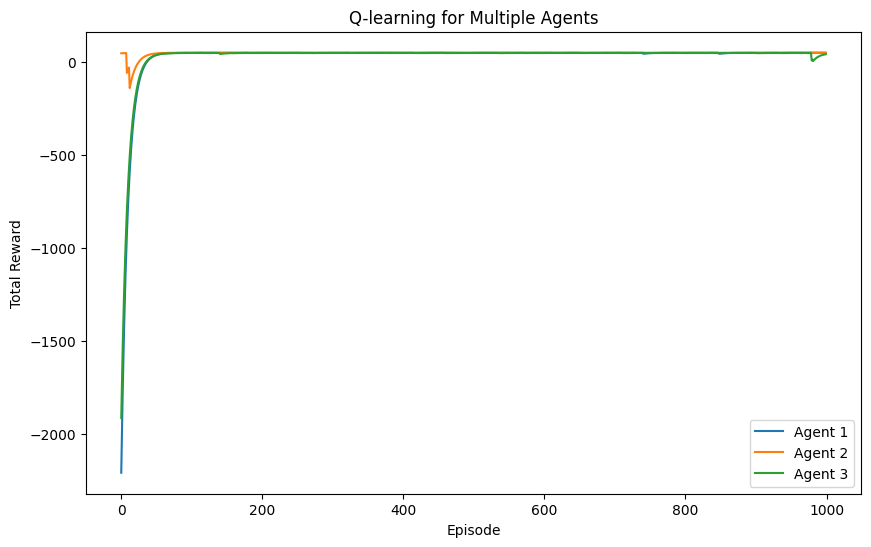

Plot saved as rewards.png
Q-table for Agent 1: {(3, 2): array([47.015     , 45.54485   , 45.54484999, 45.54485   , 48.5       ]), (2, 2): array([45.54484999, 44.08940104, 47.015     ,  0.        ,  0.        ]), (1, 2): array([44.08940123, -6.35150733, 45.54484997,  0.        , 45.54484993]), (1, 3): array([45.54484986, -4.91060097, 47.01499999, 44.08940079,  0.        ]), (0, 3): array([-4.91061261, -4.91060088, 45.54484949,  0.        ,  0.        ]), (2, 3): array([47.01499992, 45.54484993, 48.5       ,  0.        ,  0.        ]), (0, 2): array([-6.35149615, -6.35150042, 44.08940075,  0.        ,  0.        ]), (4, 2): array([45.54484999, 47.015     , 44.08940109, 44.08940008,  0.        ]), (3, 1): array([45.54484994, 44.08940072, 44.08940128, -4.91059883, 47.015     ]), (3, 0): array([ -4.91060191, -50.        ,  -6.35151214,  -4.91059936,
        45.54484998]), (2, 0): array([-49.99999998, -50.        ,  -4.9105993 ,   0.        ,
         0.        ]), (1, 0): array([-50.       

In [52]:
import time
import os
import cv2
"""
Creates and trains agents with cyclic goals (each agent's goal is another agent's start position),
then tests them in a shared environment using the safety pipeline.

Args:
    num_agents: Number of agents to create
    width: Width of the grid environment
    height: Height of the grid environment
    training_episodes: Number of episodes for training each agent
    test_steps: Maximum number of steps to run the test
"""
# # Define agent positions in a cycle (each agent's goal is the next agent's position)
agent_positions = [(3,2),(4,3),(2,4)] # Rotate to create cycle with +1 to x coordinate
goal_positions = [(3,4),(2,3),(3,2)] # Rotate to create cycle with +1 to x coordinate
width = 7
height = 7
# num_agents =4
# agent_positions, goal_positions = generate_random_positions(num_agents=num_agents, width=width, height=height, min_distance=2)

# Define some walls to make the environment more interesting
walls = [(i, 5) for i in range(3, 7)]

# Create training environment (separate environment for each agent)
train_env = MultiAgentEnvWrapper(
    is_testing=False,
    width=height,
    height=height,
    agent_positions=agent_positions,
    goal_positions=goal_positions,
    walls=walls
)

# Create and train agents
agents = []
for i in range(len(agent_positions)):
    print(f"\n===== Creating and training Agent {i+1} =====")
    agent = DynaQLearningAgent(state_dim=width*height, action_dim=5)
    agent.env_wrapper = train_env
    agent.agent_idx = i
    agents.append(agent)

# Train all agents independently
print("\n===== Training Agents =====")
training_episodes = 1000
all_rewards = train_all_agents(train_env, agents, num_episodes=training_episodes, max_steps=200)

# Plot training rewards
plot_rewards_for_all_agents(all_rewards)
Qstar = {}
# Copy Q-tables from all agents to a shared Q-table
# Create a structured dictionary to store Q-tables from all agents
for i, agent in enumerate(agents):
    Qstar[i] = agent.q_table.copy()  # Store each agent's Q-table separately
    print(f"Q-table for Agent {i+1}:", Qstar[i])
# Print sample Q-values from each agent's Q-table
for i in range(len(agents)):
    print(f"Agent {i+1} Q-values for position {agent_positions[i]}: {Qstar[i].get(agent_positions[i], 'Not found')}")
# Print Q-tables for all agents

# Create test environment (shared environment with all agents)
test_env = MultiAgentEnvWrapper(
    is_testing=True,
    width=width,
    height=height,
    agent_positions=agent_positions,
    goal_positions=goal_positions,
    walls=walls
)

# Update agents to use the test environment
for i, agent in enumerate(agents):
    agent.env_wrapper = test_env

# Visualize initial state
print("\n===== Initial Test Environment =====")
obs, info = test_env.reset()





In [53]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image
import io

def run_and_record_safety_pipeline(test_env, agents, video_name="marl_simulation.mp4", max_steps=30, 
                                  k=3, L=200, safety_threshold=-2.0, Qstars=None):
    """
    Runs the safety pipeline for multi-agent reinforcement learning and saves the visualization as a video.
    
    Args:
        test_env (MultiAgentEnvWrapper): The test environment with all agents
        agents (list): List of agent objects
        video_name (str): Name of the output video file
        max_steps (int): Maximum number of steps to run the simulation
        k (int): Safety lookahead parameter for safety_aware_pipeline
        L (int): Learning iterations parameter for safety_aware_pipeline
        safety_threshold (float): Safety threshold for determining safe actions
        Qstars (dict): Dictionary of Q-tables for all agents
        
    Returns:
        str: Path to the saved video file
    """
    # Create videos directory if it doesn't exist
    videos_dir = os.path.expanduser("~/Desktop/Projet_MARL/Videos")
    os.makedirs(videos_dir, exist_ok=True)
    
    # Full path for video file
    video_path = os.path.join(videos_dir, video_name)
    Qstar = {}
    # Copy Q-tables from all agents to a shared Q-table
    # Create a structured dictionary to store Q-tables from all agents
    for i, agent in enumerate(agents):
        Qstar[i] = agent.q_table.copy()  # Store each agent's Q-table separately
    # Reset environment
    obs, info = test_env.reset()
    
    # Initialize frame collection
    frames = []
    
    
    # Add initial state to frames 
    mask=visualize_all_agents_planned_paths(test_env, agents, k_steps=k,Qstar=Qstar)
    # Get the grid image using your visualize method with show=False
    grid_img = test_env.visualize(show=False,highlight_masks=mask)
    
    # Create a figure with the initial state
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img)
    plt.title("Initial State", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    
    # Convert matplotlib figure to image
    canvas = FigureCanvas(plt.gcf())
    canvas.draw()
    initial_frame = np.array(canvas.renderer.buffer_rgba())
    plt.close()
    frames.append(initial_frame)
    Qsteps = {}
    # Run simulation with safety pipeline
    for step in range(max_steps):
        Qsteps[step] = {}
        # Run one step of the safety pipeline
        actions,safety_status,Qstep = safety_aware_pipeline(test_env, agents, k=k, L=L, 
                                        safety_threshold=safety_threshold, Qstars=Qstars)
        Qsteps[step] = Qstep
        for i, agent in enumerate(agents):
            Qstar[i] = agent.q_table.copy() 
        mask=visualize_all_agents_planned_paths(test_env, agents, k_steps=k,Qstar=Qstar)
        # Check if all agents have reached their goals
        done = test_env.all_agents_at_goals()
        
        # Get the grid image using your visualize method with show=False
        grid_img = test_env.visualize(highlight_masks=mask,show=False)
        
        # Create a figure for this step
        plt.figure(figsize=(10, 10))
        plt.imshow(grid_img)
        plt.title(f"Step {step+1} | Actions: {actions} | Safety_status:{safety_status}", fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        
        # Convert matplotlib figure to image
        canvas = FigureCanvas(plt.gcf())
        canvas.draw()
        frame = np.array(canvas.renderer.buffer_rgba())
        plt.close()
        frames.append(frame)
        
        # Report actions taken
        print(f"Actions taken: {actions}")
        
        # Check if simulation is complete
        if done:
            print(f"All agents reached their goals in {step+1} steps!")
            
            # Get the grid image for the final state
            grid_img = test_env.visualize(show=False)
            
            # Add a success message
            plt.figure(figsize=(10, 10))
            plt.imshow(grid_img)
            plt.title(f"Success! All agents reached goals in {step+1} steps", 
                     fontsize=18, color='green')
            plt.axis('off')
            plt.tight_layout()
            
            # Convert matplotlib figure to image
            canvas = FigureCanvas(plt.gcf())
            canvas.draw()
            success_frame = np.array(canvas.renderer.buffer_rgba())
            plt.close()
            frames.append(success_frame)
            break
    
    # Now create the video writer and write all frames
    # Determine frame size from the first frame
    height, width, _ = frames[0].shape
    
    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(video_path, fourcc, 2, (width, height))  # 2 fps for easy viewing
    
    # Write frames to video
    for frame in frames:
        # Convert RGBA to BGR (OpenCV format)
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)
        video.write(frame_bgr)
    
    # Release the video writer
    video.release()
    
    print(f"Video saved to: {video_path}")
    return video_path,Qsteps
# Run the simulation and save the video



In [54]:
import numpy as np
import pandas as pd
import os
import time
from itertools import product

def flatten_qsteps(qsteps, k_value=None, L_value=None):
    """
    Aplatit la structure hiérarchique de Qsteps en lignes pour DataFrame,
    avec la position actuelle et les valeurs Q pour cette position et les positions adjacentes.
    
    Args:
        qsteps: Le dictionnaire hiérarchique à aplatir
        k_value: La valeur de k (horizon maximum) utilisée
        L_value: La valeur de L (itérations) utilisée
    
    Returns:
        list: Liste de dictionnaires, chaque dictionnaire représentant une ligne
    """
    rows = []
    for step, agents_dict in qsteps.items():
        if not agents_dict:  # Skip empty dictionaries
            continue
            
        for agent_idx, horizons_dict in agents_dict.items():
            if not horizons_dict:  # Skip empty dictionaries
                continue
                
            # Trier les horizons dans l'ordre croissant
            sorted_horizons = sorted(horizons_dict.keys(), reverse=False)
            
            # Obtenir la position actuelle de l'agent
            agent_pos = test_env.get_agent_position(idx=agent_idx)
            
            for horizon in sorted_horizons:
                qtable = horizons_dict[horizon]
                if not qtable:  # Skip empty dictionaries
                    continue
                
                # Valeurs Q pour la position actuelle
                q_current = qtable.get(agent_pos, [0, 0, 0, 0, 0])
                selected_action = np.argmax(q_current)
                
                # Positions adjacentes
                pos_up = (agent_pos[0], agent_pos[1] - 1)
                pos_down = (agent_pos[0], agent_pos[1] + 1)
                pos_left = (agent_pos[0] - 1, agent_pos[1])
                pos_right = (agent_pos[0] + 1, agent_pos[1])
                
                # Valeurs Q pour les positions adjacentes
                q_up = qtable.get(pos_up, [0, 0, 0, 0, 0])
                q_down = qtable.get(pos_down, [0, 0, 0, 0, 0])
                q_left = qtable.get(pos_left, [0, 0, 0, 0, 0])
                q_right = qtable.get(pos_right, [0, 0, 0, 0, 0])
                
                # Créer une ligne avec les informations demandées
                row = {
                    'k': k_value,
                    'L': L_value,
                    'Step': step,
                    'Agent': agent_idx,
                    'Horizon': horizon,
                    'CurrentPos': agent_pos,
                    'Selected_Action': selected_action,
                    'Q_Current': q_current,
                    'Pos_Up': pos_up,
                    'Q_Up': q_up,
                    'Pos_Down': pos_down,
                    'Q_Down': q_down,
                    'Pos_Left': pos_left,
                    'Q_Left': q_left,
                    'Pos_Right': pos_right,
                    'Q_Right': q_right
                }
                rows.append(row)
    
    return rows
# Définir les plages de valeurs pour L et k
L_values = [ 200, 500,600,800,1000,1500]
k_values = [2, 3,4]

# Créer un dossier pour les résultats si nécessaire
results_dir = os.path.expanduser("~/Desktop/Projet_MARL/Results")
os.makedirs(results_dir, exist_ok=True)

# Liste pour collecter toutes les données pour CSV
all_rows = []

# Exécuter la simulation pour chaque combinaison de paramètres
for k, L in product(k_values, L_values):
    print(f"\n\n===== Running with k={k}, L={L} =====")
    
    # Créer un nom de fichier vidéo basé sur les paramètres
    video_name = f"easy_ex_k{k}_L{L}.mp4"
    
    # Réinitialiser l'environnement de test et les agents pour une nouvelle exécution
    test_env = MultiAgentEnvWrapper(
        is_testing=True,
        width=width,
        height=height,
        agent_positions=agent_positions,
        goal_positions=goal_positions,
        walls=walls
    )
    
    # Mettre à jour les agents avec l'environnement de test réinitialisé
    for i, agent in enumerate(agents):
        agent.env_wrapper = test_env
        # Restaurer la Q-table originale pour chaque agent
        agent.q_table = Qstar[i].copy()
    
    # Lancer la simulation avec cette combinaison de paramètres
    print(f"Running simulation with k={k}, L={L}...")
    video_path, Qsteps = run_and_record_safety_pipeline(
        test_env, agents, 
        video_name=video_name, 
        max_steps=40,
        k=k, 
        L=L, 
        safety_threshold=-2.0, 
        Qstars=Qstar
    )
    
    # Aplatir les données de Qsteps avec les valeurs de k et L
    flattened_data = flatten_qsteps(Qsteps, k_value=k, L_value=L)
    
    # Ajouter les données à la liste complète
    all_rows.extend(flattened_data)
    
    # Sauvegarder les données pour cette combinaison de paramètres
    df_current = pd.DataFrame(flattened_data)
    if not df_current.empty:
        df_current.to_csv(os.path.join(results_dir, f"qsteps_k{k}_L{L}.csv"), index=False)
        print(f"CSV saved for k={k}, L={L}")

# Créer un DataFrame avec toutes les données
df_all = pd.DataFrame(all_rows)

# Sauvegarder le CSV combiné
combined_csv_path = os.path.join(results_dir, "all_parameters_qsteps.csv")
df_all.to_csv(combined_csv_path, index=False)

print(f"\nCombined CSV with all parameters saved to: {combined_csv_path}")



===== Running with k=2, L=200 =====
Running simulation with k=2, L=200...
Planned path for Agent 1: [(3, 2), (3, 3), (3, 4)]
Planned path for Agent 2: [(4, 3), (3, 3), (2, 3)]
Planned path for Agent 3: [(2, 4), (3, 4), (3, 3)]
rewards -60
rewards 50
rewards -2
rewards 50
rewards 100
rewards 40
rewards 50
rewards 50
rewards 50
rewards 50
rewards 40
rewards 50
rewards 50
rewards 0.0
rewards 50
rewards 40
rewards 50
rewards -50
rewards 50
rewards -50
rewards -60
rewards 50
rewards 50
rewards 50
rewards -2
rewards 40
rewards 50
rewards 50
rewards -2
rewards 50
rewards -60
rewards 100
rewards -2
rewards 50
rewards 50
rewards -12
rewards -50
rewards 50
rewards -50
rewards 50
rewards 40
rewards -2
rewards 0.0
rewards 50
rewards 50
rewards -60
rewards 50
rewards 50
rewards 50
rewards -2
rewards -10
rewards 0
rewards 0
rewards 0
rewards -2
rewards -12
rewards 0
rewards 0
rewards 0
rewards 0
rewards -10
rewards -2
rewards 0
rewards 0
rewards 0
rewards -10
rewards 0
rewards 0
rewards -2
rewards

In [ ]:
import os
import cv2
import numpy as np
from glob import glob

def combine_videos(input_dir, output_file):
    """
    Combine all videos in a directory into a single video, adding k and L labels.
    
    Args:
        input_dir: Directory containing the videos
        output_file: Path to save the output video
    """
    # Expand user directory if needed
    input_dir = os.path.expanduser(input_dir)
    output_file = os.path.expanduser(output_file)
    
    # Create directory for output file if it doesn't exist
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    # Find all videos in the directory
    video_files = glob(os.path.join(input_dir, "15x15_8ag_k*_L*.mp4"))
    
    # Sort videos by k and L values
    def extract_k_L(filename):
        basename = os.path.basename(filename)
        k = int(basename.split('_k')[1].split('_')[0])
        L = int(basename.split('_L')[1].split('.')[0])
        return (k, L)
    
    video_files.sort(key=extract_k_L)
    
    if not video_files:
        print(f"No videos found in {input_dir}")
        return
    
    print(f"Found {len(video_files)} videos to combine")
    
    # Open the first video to get properties
    sample = cv2.VideoCapture(video_files[0])
    width = int(sample.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(sample.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = sample.get(cv2.CAP_PROP_FPS)
    sample.release()
    
    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))
    
    # Process each video
    for video_file in video_files:
        # Extract k and L values from filename
        basename = os.path.basename(video_file)
        k = basename.split('_k')[1].split('_')[0]
        L = basename.split('_L')[1].split('.')[0]
        label = f"k={k}, L={L}"
        
        print(f"Processing {basename} ({label})")
        
        # Open the video
        cap = cv2.VideoCapture(video_file)
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Add label with k and L values
            cv2.putText(
                frame, 
                label, 
                (30, 60),  # Position: top-left with some padding
                cv2.FONT_HERSHEY_SIMPLEX, 
                2,  # Font scale
                (255, 0, 0),  # Color (BGR): red
                3,  # Thickness
                cv2.LINE_AA
            )
            
            # Write frame to output video
            out.write(frame)
        
        # Add 2 second pause (black frames) between videos
        pause_frames = int(fps * 2)
        for _ in range(pause_frames):
            black_frame = np.zeros((height, width, 3), dtype=np.uint8)
            cv2.putText(
                black_frame, 
                f"Next: {label}", 
                (width//4, height//2),
                cv2.FONT_HERSHEY_SIMPLEX, 
                2, 
                (255, 255, 255),
                3, 
                cv2.LINE_AA
            )
            out.write(black_frame)
        
        cap.release()
    
    # Release the output video
    out.release()
    print(f"Combined video saved to {output_file}")

# Define input directory and output file
input_dir = "~/Desktop/Projet_MARL/Results/10-10_6ag/videos"
output_file = "~/Desktop/Projet_MARL/Results/10-10_6ag/videos/combined_all_params_video.mp4"

# Combine all videos
combine_videos(input_dir, output_file)

No videos found in /home/yacine/Desktop/Projet_MARL/Results/10-10_6ag/videos


In [ ]:
from itertools import product

In [23]:

def select_action_with_qtable(qtable, state, action_dim=5):
    """
    Select the best action based on the provided Q-table.
    
    Args:
        qtable: The Q-table dictionary
        state: The current state (position)
        action_dim: Number of possible actions
        
    Returns:
        int: The best action according to the Q-table
    """
    state_key = tuple(state) if isinstance(state, np.ndarray) else state
    
    if state_key in qtable:
        return np.argmax(qtable[state_key])
    else:
        # If state not in Q-table, return default action
        return 0  # Default: stay in place

def n_steps_safety_judger_qtable(n_steps, env, agents, safety_threshold=-40.0,Qstars=None):
    """
    Evaluates if agent trajectories over n steps are safe using Q-tables.
    
    Args:
        n_steps: Number of steps to look ahead
        env: Environment wrapper
        agents: List of agent objects with Q-tables
        safety_threshold: Reward threshold to judge safety
        
    Returns:
        numpy.ndarray: Boolean array indicating if each agent is safe
    """
    judge = np.ones(len(agents), dtype=bool)  # Initialize to True for all agents
    
    # Get current positions of all agents
    current_positions = [env.get_agent_position(idx=i) for i in range(len(agents))]
    next_positions = current_positions.copy()

    # Forecast for each agent over n steps and check safety
    for agent_idx in range(len(agents)):
        current_state = next_positions[agent_idx]
        
        
        if Qstar[agent_idx] is None:
            qtable = agents[agent_idx].q_table
        else:
            qtable = Qstar[agent_idx]
        # Simulate n steps for this agent
        for step in range(n_steps):
            # Select action using the provided Q-table
            action = select_action_with_qtable(qtable, current_state)
            
            # Use model to simulate action and get reward
            reward, next_state, _ = model(env, agent_idx, current_state, action)
            
            # If reward is below safety threshold, agent is not safe
            if reward <= safety_threshold:
                judge[agent_idx] = False
                break  # No need to continue for this agent
                
            current_state = next_state  # Update state for next step
        
        # Update final position after n steps
        next_positions[agent_idx] = current_state
    
    return judge
def visualize_agent_planned_path_qtable(env, agent_idx, qtable, k_steps=5, fixed_color=None):
    """
    Creates a highlight mask showing the planned path for an agent over k steps using Q-table.
    
    Args:
        env: The environment wrapper
        agent_idx: Index of the agent
        qtable: Q-table to use for action selection
        k_steps: Number of steps to look ahead
        fixed_color: Optional color index to use for path visualization
        
    Returns:
        np.ndarray: A highlight mask showing the planned path
    """
    # Create a 2D array of lists for the highlight mask
    mask = np.empty((env.width, env.height), dtype=object)
    for i in range(env.width):
        for j in range(env.height):
            mask[i, j] = []
    
    # Get the agent's current position
    current_pos = env.get_agent_position(idx=agent_idx)
    
    # Get reference to the world object for colors
    env_world = env.envs[0].world
    color_count = len(env_world.IDX_TO_COLOR)
    
    # Add the current position to the path with step 0
    x, y = current_pos
    step_color = 0 if fixed_color is None else fixed_color
    mask[x, y].append(step_color)
    
    # Simulate the agent's path for k steps
    simulated_pos = current_pos
    path = [current_pos]
    
    # Get unsafe set for simulation
    
    for step in range(k_steps):
        # Select action according to the provided Q-table
        action = select_action_with_qtable(qtable, simulated_pos)
        
        # Simulate the action
        _, next_pos, _ ,_= model(env, agent_idx, simulated_pos, action)
        
        # Add the next position to the path with appropriate color
        x, y = next_pos
        step_color = (step+1) % color_count if fixed_color is None else fixed_color
        mask[x, y].append(step_color)
        
        # Update for next iteration
        simulated_pos = next_pos
        path.append(next_pos)
        
        # Break if the agent reaches its goal
        if next_pos == env.get_agent_goal(idx=agent_idx):
            break
    
    print(f"Planned path for Agent {agent_idx+1}: {path}")
    return mask
def visualize_all_agents_planned_paths(env, agents, k_steps=5, Qstar=None):
    """
    Creates a merged highlight mask showing the planned paths for all agents.
    
    Args:
        env: The environment wrapper
        agents: List of agent objects with Q-tables
        k_steps: Number of steps to look ahead
        Qstar: Optional list of Q-tables to use instead of agents' Q-tables
        
    Returns:
        np.ndarray: A highlight mask showing all planned paths
    """
    # Create a 2D array of lists for the combined highlight mask
    combined_mask = np.empty((env.width, env.height), dtype=object)
    for i in range(env.width):
        for j in range(env.height):
            combined_mask[i, j] = []
    
    # Generate path for each agent and add to the combined mask
    for agent_idx in range(len(agents)):
        # Use visualize_agent_planned_path_qtable for each agent
        if Qstar is not None and agent_idx < len(Qstar) and Qstar[agent_idx] is not None:
            qtable = Qstar[agent_idx]
        else:
            qtable = agents[agent_idx].q_table
                    
            # Get agent's mask with a fixed color (the agent's index)
        agent_mask = visualize_agent_planned_path_qtable(
            env, 
            agent_idx, 
            qtable, 
            k_steps=k_steps, 
            fixed_color=agent_idx % len(env.envs[0].world.IDX_TO_COLOR)
        )
        # Merge the agent's mask with the combined mask
        for i in range(env.width):
            for j in range(env.height):
                if agent_mask[i, j]:
                    combined_mask[i, j].extend(agent_mask[i, j])
    
    return combined_mask
